## 1. Importing datsets

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
full_dataset3 = pd.read_csv('datasets\\full_dataset_4.csv')

## 2. Balancing data

In [3]:
def plot_count(count):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    count0 = counter[0]
    count1 = counter[1]
    total = count0 + count1
    amount = (count0/total, count1/total)

    ax.barh([0,1], amount, align='center')
    ax.set_yticks([0,1])
    ax.set_yticklabels([0,1])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('% of data')
    ax.set_ylabel('Hate detection')
    ax.set_title('Data distribution')
    
    a = round(amount[0], 3)
    ax.text(a, 0, str(a*100) + '%', color='black')
    b = round(amount[1], 3)
    ax.text(b, 1, str(b*100) + '%', color='black')

    plt.xlim([0.0, 1.0])
    plt.show()

In [4]:
counter = Counter(full_dataset3['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 5290, Class 1: 1431


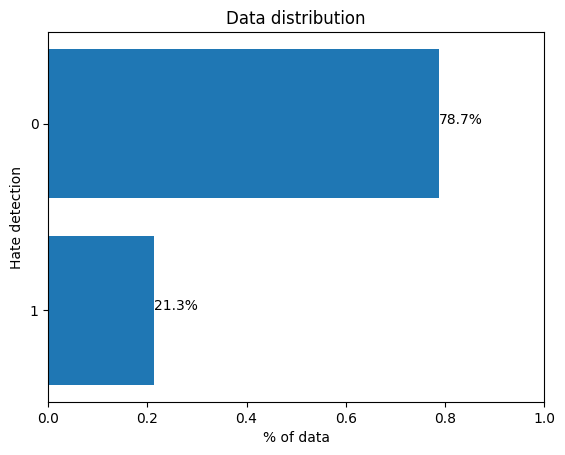

In [5]:
plot_count(counter)

In [6]:
full_dataset3_unbalanced = full_dataset3.copy()

### 2.1 Balancing through translation (oversampling)
The idea here is to translate to a random language and then back to portuguese. This will add random changes to the smaller class.

In [7]:
from textblob import TextBlob
from textblob.translate import NotTranslated
import random
from tqdm import tqdm
import time

from collections import Counter

from pandas import DataFrame
from sklearn.utils import shuffle

In [8]:
language = ["fr", "la", "es", "de", "it", "en", "ru", "zh", "fi"]

sr = random.SystemRandom()
def data_augmentation_translate(dataframe, class_values=[0,1]):
    count0 = dataframe[dataframe.hate_speech==class_values[0]].count()
    count1 = dataframe[dataframe.hate_speech==class_values[1]].count()
    
    aug_range = abs(count0.text - count1.text)
    
    list_messages = dataframe[dataframe.hate_speech==class_values[1]]['text'].tolist()
    
    len_list = len(list_messages)
    augmented_messages = []

    for j in tqdm(range(0, aug_range)):
        ind = random.randint(0, len_list)
        message = list_messages[ind-1]
        
        if hasattr(message, "decode"):
            message = message.decode("utf-8")
        
        text = TextBlob(message)
        try:
            text = text.translate(to=sr.choice(language))   ## Converting to random langauge for meaningful variation
            time.sleep(2)
            text = text.translate(to="pt")
        except NotTranslated:
            pass
        augmented_messages.append([str(text), 1])

    df = DataFrame(augmented_messages)
    df.columns = ['text', 'hate_speech']
    
    data = pd.concat([dataframe, df])

    return shuffle(data)

In [9]:
try:
    full_dataset3_balanced_translate = pd.read_csv('datasets\\full_dataset3_balanced_translate.csv')
except FileNotFoundError:
    full_dataset3_balanced_translate = data_augmentation_translate(full_dataset3_unbalanced)
    full_dataset3_balanced_translate.to_csv('datasets\\full_dataset3_balanced_translate.csv', index=False)

In [10]:
counter = Counter(full_dataset3_balanced_translate['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 5271, Class 1: 5271


### 2.2 Balancing through repetition (oversampling)
Now, we will just repeat some elements of the smaller class. This can generate some problems, such as skew the project.

In [11]:
def data_augmentation_repeating(dataframe, class_values=[0,1]):
    count0 = dataframe[dataframe.hate_speech==class_values[0]].count()
    count1 = dataframe[dataframe.hate_speech==class_values[1]].count()
    
    aug_range = abs(count0.text - count1.text)
    
    list_messages = dataframe[dataframe.hate_speech==class_values[1]]['text'].tolist()
    
    len_list = len(list_messages)
    augmented_messages = []

    for j in range(aug_range):
        ind = random.randint(0, len_list)
        message = list_messages[ind-1]
        
        augmented_messages.append([message, 1])

    df = DataFrame(augmented_messages)
    df.columns = ['text', 'hate_speech']
    
    data = pd.concat([dataframe, df])

    return shuffle(data)

In [12]:
full_dataset3_balanced_repeating = data_augmentation_repeating(full_dataset3_unbalanced)

In [13]:
counter = Counter(full_dataset3_balanced_repeating['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 5290, Class 1: 5290


### 2.3 Balancing through removing random elements (undersampling)

In [14]:
def undersampling(dataframe, class_values=[0,1]):
    count0 = dataframe[dataframe.hate_speech==class_values[0]].count()
    count1 = dataframe[dataframe.hate_speech==class_values[1]].count()
    
    df1 = dataframe[dataframe.hate_speech==class_values[1]]
    
    diff = abs(count0.text - count1.text)
    list_messages = dataframe[dataframe.hate_speech==class_values[0]]['text'].tolist()

    for j in range(diff):
        ind = random.randint(0, len(list_messages))
        del list_messages[ind-1]

    df = DataFrame({'text':list_messages, 'hate_speech': np.repeat(0, len(list_messages))})
    
    data = pd.concat([df1, df])

    return shuffle(data)

In [15]:
full_dataset3_balanced_undersampling = undersampling(full_dataset3_unbalanced)

In [16]:
counter = Counter(full_dataset3_balanced_undersampling['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 1431, Class 1: 1431


## 3. Preprocessing data

In [17]:
import nltk
#nltk.download('stopwords')
#nltk.download('rslp')
from unidecode import unidecode
stem = nltk.stem.RSLPStemmer()

In [18]:
stopwords = set(nltk.corpus.stopwords.words('portuguese')) # get stop words in portuguese

def remove_stopwords(text):
    text_without_stopwords = [word for word in text.split() if word not in stopwords]
    # some elements of the dataset were only stopwords (eg: "quando foi isso")
    # if it's the case, we'll return the same text
    if text_without_stopwords == []:
        return text
    return ' '.join(text_without_stopwords)

def cleaning_data(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'rt+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[\"!$%-*&’‘*+”“,-./\[\]<=>\'?():;^_`<>{|}~@]', '', text)
    return text

def tagging(text):
    text = re.sub(r'[0-9]', '', text)
    text = text.lower()
    text = re.sub(r'nao', '_NAO', text)
    text = re.sub(r'não', '_NAO', text)
    text = text.replace('?', '_Q')
    text = text.replace('!', '_E')
    return text

def stemming(text):
    text = text.split()
    new_text = []
    for word in text:
        new_text.append(stem.stem(word))
    return ' '.join(new_text)

def preprocessing1(text):
    text = tagging(text)
    text = remove_stopwords(text)
    text = cleaning_data(text)
    text = unidecode(text) #remove accents (e.g.: á, ã, à will be "a")
    return text.split()

def preprocessing2(text):
    text = tagging(text)
    text = remove_stopwords(text)
    text = cleaning_data(text)
    text = stemming(text)
    text = unidecode(text) #remove accents (e.g.: á, ã, à will be "a")
    return text.split()


In [19]:
f = open("datasets\\lista-palavroes-bloqueio.txt", "r", encoding="utf8")
list_bad_words = f.readlines()
list_bad_words = [x.strip() for x in list_bad_words]
f.close()

def tagging_swearwords(text):
    text = [word if (word.upper() not in list_bad_words) else "_SWEARWORD" for word in text.split()]
    text = ' '.join(text)
    return text

def tagging_laughs(text):
    return re.sub(r'k{2,}|a*ha+h[ha]*|e*he+h[he]*|s*rs+r[rs]*', '_LAUGHS ', text)

def preprocessing3(text):
    text = tagging(text)
    text = remove_stopwords(text)
    text = cleaning_data(text)
    text = unidecode(text) #remove accents (e.g.: á, ã, à will be "a")
    text = tagging_swearwords(text)
    text = tagging_laughs(text)
    return text.split()

def preprocessing4(text):
    text = tagging(text)
    text = remove_stopwords(text)
    text = cleaning_data(text)
    text = stemming(text)
    text = unidecode(text) #remove accents (e.g.: á, ã, à will be "a")
    text = tagging_swearwords(text)
    text = tagging_laughs(text)
    return text.split()

## 4. Feature extraction

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

### 4.1 Bag of Words (BoW): CountVectorizer

In [21]:
full_dataset3_balanced_undersampling

,text,hate_speech
771,"Estou aguardando algum pedido c/ burca, ou ser...",0
4894,idiota é pensar q no dia d mulher eu aquela mu...,1
4781,"eu devo ser mt feia, pq gorda eu já sou...",1
1012,"Porra, que lixo, que idiotas... o mundo está à...",0
405,Nas Principais Nações da UE Maioria Apoia Veto...,0
...,...,...
6648,'quando sua me devolver o troco de R pelo ser...,1
5370,RT @alerodrigues247: Como ser feminista:\nSer ...,1
464,e tem nordestino e manaura achando ruim das pi...,1
4468,ia perguntar se o dia Internacional da mulher ...,1


In [22]:
bow_transformer1 = CountVectorizer(analyzer=preprocessing1).fit_transform(full_dataset3_balanced_translate['text'])
bow_transformer1

<10542x17606 sparse matrix of type '<class 'numpy.int64'>'
	with 90354 stored elements in Compressed Sparse Row format>

In [23]:
bow_transformer2 = CountVectorizer(analyzer=preprocessing2).fit_transform(full_dataset3_balanced_translate['text'])
bow_transformer2

<10542x10868 sparse matrix of type '<class 'numpy.int64'>'
	with 89740 stored elements in Compressed Sparse Row format>

In [24]:
bow_transformer3 = CountVectorizer(analyzer=preprocessing3).fit_transform(full_dataset3_balanced_translate['text'])
bow_transformer3

<10542x17425 sparse matrix of type '<class 'numpy.int64'>'
	with 90119 stored elements in Compressed Sparse Row format>

In [25]:
bow_transformer4 = CountVectorizer(analyzer=preprocessing4).fit_transform(full_dataset3_balanced_translate['text'])
bow_transformer4

<10542x10760 sparse matrix of type '<class 'numpy.int64'>'
	with 89775 stored elements in Compressed Sparse Row format>

In [26]:
print(bow_transformer4)

  (0, 7327)	1
  (0, 7035)	1
  (0, 4796)	1
  (0, 7099)	1
  (0, 8217)	1
  (0, 6829)	1
  (1, 7099)	1
  (1, 6747)	1
  (1, 5497)	1
  (1, 4446)	1
  (1, 8587)	1
  (1, 3559)	1
  (2, 9010)	1
  (2, 8408)	1
  (2, 8612)	1
  (2, 3020)	1
  (3, 6829)	1
  (3, 4374)	1
  (3, 4036)	1
  (3, 10031)	1
  (3, 4565)	1
  (3, 9529)	1
  (3, 2489)	1
  (3, 10183)	1
  (3, 3990)	1
  :	:
  (10537, 1705)	1
  (10537, 3252)	1
  (10537, 9280)	1
  (10538, 7356)	1
  (10538, 9346)	1
  (10538, 5779)	1
  (10538, 3718)	1
  (10538, 6361)	1
  (10538, 4749)	1
  (10539, 6698)	2
  (10539, 5912)	1
  (10539, 7012)	1
  (10539, 10263)	1
  (10539, 6143)	1
  (10539, 10607)	1
  (10539, 9065)	1
  (10539, 7350)	1
  (10540, 8217)	1
  (10540, 3388)	1
  (10540, 10408)	1
  (10540, 6723)	1
  (10541, 9121)	1
  (10541, 4510)	1
  (10541, 9988)	1
  (10541, 2545)	1


### 4.2 TF-IDF

In [27]:
tfidf = TfidfTransformer().fit_transform(bow_transformer4)

In [28]:
print(tfidf)

  (0, 8217)	0.29468785776246925
  (0, 7327)	0.6440191061171336
  (0, 7099)	0.17372974443568506
  (0, 7035)	0.37159201278750287
  (0, 6829)	0.43013735550482085
  (0, 4796)	0.38094312537912806
  (1, 8587)	0.4921518850743763
  (1, 7099)	0.15681292864314836
  (1, 6747)	0.4280399448196982
  (1, 5497)	0.43720281758557505
  (1, 4446)	0.2917671887060007
  (1, 3559)	0.5231669302972789
  (2, 9010)	0.6039551848333548
  (2, 8612)	0.40482750988650024
  (2, 8408)	0.5285994173330578
  (2, 3020)	0.43810441443468207
  (3, 10183)	0.22399905680432625
  (3, 10031)	0.29161065476926384
  (3, 9529)	0.22082291100770993
  (3, 6829)	0.24802654427000712
  (3, 5734)	0.3143999508773477
  (3, 4698)	0.34896282152836966
  (3, 4565)	0.4017402555344906
  (3, 4374)	0.18378182549209188
  (3, 4036)	0.27929699863197666
  :	:
  (10537, 1265)	0.34642483787174355
  (10537, 894)	0.3221434702412208
  (10537, 0)	0.26904941075911776
  (10538, 9346)	0.29442674742375285
  (10538, 7356)	0.2883783232953457
  (10538, 6361)	0.513056814

## 5. Machine learning!

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

In [30]:
# unbalanced
text3_unb = full_dataset3_unbalanced['text']
class3_unb = full_dataset3_unbalanced['hate_speech']

# balanced translated
text3_tra = full_dataset3_balanced_translate['text']
class3_tra = full_dataset3_balanced_translate['hate_speech']

# balanced repeating
text3_rep = full_dataset3_balanced_repeating['text']
class3_rep = full_dataset3_balanced_repeating['hate_speech']

# balanced undersampling
text3_und = full_dataset3_balanced_undersampling['text']
class3_und = full_dataset3_balanced_undersampling['hate_speech']


### 5.1 Splitting the data: train, test and validation

In [31]:
# data = [x_train, x_test, y_train, y_test]

X_train_unb, X_test_unb, y_train_unb, y_test_unb = train_test_split(text3_unb, class3_unb, test_size=0.2, random_state=1)
X_train_unb, X_val_unb, y_train_unb, y_val_unb = train_test_split(X_train_unb, y_train_unb, test_size=0.25, random_state=1)

X_train_tra, X_test_tra, y_train_tra, y_test_tra = train_test_split(text3_tra, class3_tra, test_size=0.2, random_state=1)
X_train_tra, X_val_tra, y_train_tra, y_val_tra = train_test_split(X_train_tra, y_train_tra, test_size=0.25, random_state=1)

X_train_rep, X_test_rep, y_train_rep, y_test_rep = train_test_split(text3_rep, class3_rep, test_size=0.2, random_state=1)
X_train_rep, X_val_rep, y_train_rep, y_val_rep = train_test_split(X_train_rep, y_train_rep, test_size=0.25, random_state=1)

X_train_und, X_test_und, y_train_und, y_test_und = train_test_split(text3_und, class3_und, test_size=0.2, random_state=1)
X_train_und, X_val_und, y_train_und, y_val_und = train_test_split(X_train_und, y_train_und, test_size=0.25, random_state=1)


In [32]:
# arrays to save results
f1_val = np.zeros((12, 8))
f1_test = np.zeros((12, 8))

In [33]:
def predict_test(X, y, pipeline):
    result = pipeline.predict(X)
    print(confusion_matrix(y, result))
    return f1_score(y, result, average='weighted')

### 5.2 ML models

#### 5.2.1 RandomForestClassifier

In [34]:
max_depth_values = range(1, 11)
def random_forest_eval(data):
    best = None
    diff = 1
    train_scores = []
    val_scores = []
    for i in max_depth_values:
        clf = RandomForestClassifier(max_depth=i)
        pipeline = Pipeline([
                            ('bow', CountVectorizer(analyzer=preprocessing4, ngram_range=(1,1))),  # strings to token integer counts
                            ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
                            ('classifier', clf) # train on TF-IDF vectors w/ LinearSVC classifier
                            ])
        
        pipeline.fit(data[0], data[2])
        
        train_predict = pipeline.predict(data[0])
        train_accuracy = f1_score(data[2], train_predict, average='weighted')
        train_scores.append(train_accuracy)
        
        val_predict = pipeline.predict(data[1])
        val_accuracy = f1_score(data[3], val_predict, average='weighted')
        val_scores.append(val_accuracy)  

    return [train_scores, val_scores]


In [35]:
scores_data3_unbalanced = random_forest_eval([X_train_unb, X_val_unb, y_train_unb, y_val_unb])
scores_data3_balanced_translate = random_forest_eval([X_train_tra, X_val_tra, y_train_tra, y_val_tra])
scores_data3_balanced_repeating = random_forest_eval([X_train_rep, X_val_rep, y_train_rep, y_val_rep])
scores_data3_balanced_undersampl = random_forest_eval([X_train_und, X_val_und, y_train_und, y_val_und])

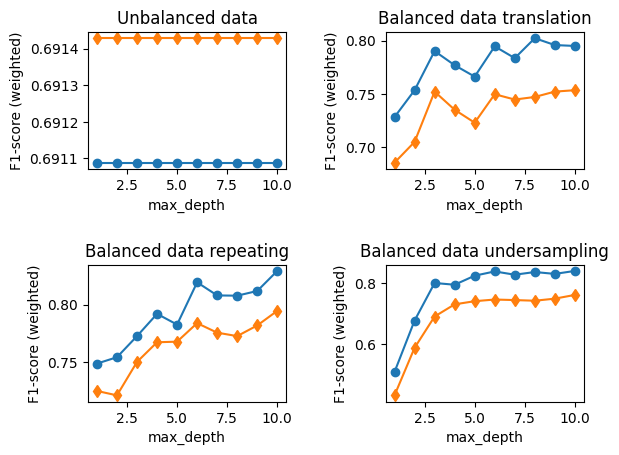

In [36]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(max_depth_values, scores_data3_unbalanced[0], '-o', label='Train')
axs[0, 0].plot(max_depth_values, scores_data3_unbalanced[1], '-d', label='Test')
axs[0, 0].set_title('Unbalanced data')
axs[0, 1].plot(max_depth_values, scores_data3_balanced_translate[0], '-o', label='Train')
axs[0, 1].plot(max_depth_values, scores_data3_balanced_translate[1], '-d', label='Test')
axs[0, 1].set_title('Balanced data translation')
axs[1, 0].plot(max_depth_values, scores_data3_balanced_repeating[0], '-o', label='Train')
axs[1, 0].plot(max_depth_values, scores_data3_balanced_repeating[1], '-d', label='Test')
axs[1, 0].set_title('Balanced data repeating')
axs[1, 1].plot(max_depth_values, scores_data3_balanced_undersampl[0], '-o', label='Train')
axs[1, 1].plot(max_depth_values, scores_data3_balanced_undersampl[1], '-d', label='Test')
axs[1, 1].set_title('Balanced data undersampling')

for ax in axs.flat:
    ax.set(xlabel='max_depth', ylabel='F1-score (weighted)')

plt.subplots_adjust(hspace=0.7, wspace = 0.5)

plt.show()

In [37]:
rfc = RandomForestClassifier(max_depth=5) # max_depth chosen based on graph above

def random_forest(X_train, X_val, y_train, y_val, preproc):
    rfc_bow = Pipeline([
        ('bow', CountVectorizer(analyzer=preproc, ngram_range=(1,1))),  # strings to token integer counts
        ('classifier', rfc),  # train on TF-IDF vectors w/ LinearSVC classifier
    ])

    rfc_bow.fit(X_train, y_train)
    result_val1 = rfc_bow.predict(X_val)
    print('BOW')
    print(confusion_matrix(y_val, result_val1))
    f1_bow = f1_score(y_val, result_val1, average='weighted')
    
    rfc_tfidf = Pipeline([
        ('bow', CountVectorizer(analyzer=preproc, ngram_range=(1,1))),
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('classifier', rfc),
    ])
    
    rfc_tfidf.fit(X_train, y_train)
    result_val2 = rfc_tfidf.predict(X_val)
    print('TF-IDF')
    print(confusion_matrix(y_val, result_val2))
    f1_tfidf = f1_score(y_val, result_val2, average='weighted')
    
    return f1_bow, f1_tfidf, rfc_bow, rfc_tfidf
    

In [38]:
print('UNBALANCED')
f1_val[0][0], f1_val[0][1], rfc_bow_unb1, rfc_tfidf_unb1 = random_forest(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing1)
f1_test[0][0] = predict_test(X_test_unb, y_test_unb, rfc_bow_unb1)
f1_test[0][1] = predict_test(X_test_unb, y_test_unb, rfc_tfidf_unb1)

f1_val[3][0], f1_val[3][1], rfc_bow_unb2, rfc_tfidf_unb2 = random_forest(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing2)
f1_test[3][0] = predict_test(X_test_unb, y_test_unb, rfc_bow_unb2)
f1_test[3][1] = predict_test(X_test_unb, y_test_unb, rfc_tfidf_unb2)

f1_val[6][0], f1_val[6][1], rfc_bow_unb3, rfc_tfidf_unb3 = random_forest(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing3)
f1_test[6][0] = predict_test(X_test_unb, y_test_unb, rfc_bow_unb3)
f1_test[6][1] = predict_test(X_test_unb, y_test_unb, rfc_tfidf_unb3)

f1_val[9][0], f1_val[9][1], rfc_bow_unb4, rfc_tfidf_unb4 = random_forest(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing4)
f1_test[9][0] = predict_test(X_test_unb, y_test_unb, rfc_bow_unb4)
f1_test[9][1] = predict_test(X_test_unb, y_test_unb, rfc_tfidf_unb4)


print('UNDERSAMPLING')
f1_val[0][2], f1_val[0][3], rfc_bow_und1, rfc_tfidf_und1 = random_forest(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing1)
f1_test[0][2] = predict_test(X_test_und, y_test_und, rfc_bow_und1)
f1_test[0][3] = predict_test(X_test_und, y_test_und, rfc_tfidf_und1)

f1_val[3][2], f1_val[3][3], rfc_bow_und2, rfc_tfidf_und2 = random_forest(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing2)
f1_test[3][2] = predict_test(X_test_und, y_test_und, rfc_bow_und2)
f1_test[3][3] = predict_test(X_test_und, y_test_und, rfc_tfidf_und2)

f1_val[6][2], f1_val[6][3], rfc_bow_und3, rfc_tfidf_und3 = random_forest(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing3)
f1_test[6][2] = predict_test(X_test_und, y_test_und, rfc_bow_und3)
f1_test[6][3] = predict_test(X_test_und, y_test_und, rfc_tfidf_und3)

f1_val[9][2], f1_val[9][3], rfc_bow_und4, rfc_tfidf_und4 = random_forest(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing4)
f1_test[9][2] = predict_test(X_test_und, y_test_und, rfc_bow_und4)
f1_test[9][3] = predict_test(X_test_und, y_test_und, rfc_tfidf_und4)


print('REPEATING')
f1_val[0][4], f1_val[0][5], rfc_bow_rep1, rfc_tfidf_rep1 = random_forest(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing1)
f1_test[0][4] = predict_test(X_test_rep, y_test_rep, rfc_bow_rep1)
f1_test[0][5] = predict_test(X_test_rep, y_test_rep, rfc_tfidf_rep1)

f1_val[3][4], f1_val[3][5], rfc_bow_rep2, rfc_tfidf_rep2 = random_forest(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing2)
f1_test[3][4] = predict_test(X_test_rep, y_test_rep, rfc_bow_rep2)
f1_test[3][5] = predict_test(X_test_rep, y_test_rep, rfc_tfidf_rep2)

f1_val[6][4], f1_val[6][5], rfc_bow_rep3, rfc_tfidf_rep3 = random_forest(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing3)
f1_test[6][4] = predict_test(X_test_rep, y_test_rep, rfc_bow_rep3)
f1_test[6][5] = predict_test(X_test_rep, y_test_rep, rfc_tfidf_rep3)

f1_val[9][4], f1_val[9][5], rfc_bow_rep4, rfc_tfidf_rep4 = random_forest(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing4)
f1_test[9][4] = predict_test(X_test_rep, y_test_rep, rfc_bow_rep4)
f1_test[9][5] = predict_test(X_test_rep, y_test_rep, rfc_tfidf_rep4)

print('TRANSLATION')
f1_val[0][6], f1_val[0][7], rfc_bow_tra1, rfc_tfidf_tra1 = random_forest(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing1)
f1_test[0][6] = predict_test(X_test_tra, y_test_tra, rfc_bow_tra1)
f1_test[0][7] = predict_test(X_test_tra, y_test_tra, rfc_tfidf_tra1)

f1_val[3][6], f1_val[3][7], rfc_bow_tra2, rfc_tfidf_tra2 = random_forest(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing2)
f1_test[3][6] = predict_test(X_test_tra, y_test_tra, rfc_bow_tra2)
f1_test[3][7] = predict_test(X_test_tra, y_test_tra, rfc_tfidf_tra2)

f1_val[6][6], f1_val[6][7], rfc_bow_tra3, rfc_tfidf_tra3 = random_forest(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing3)
f1_test[6][6] = predict_test(X_test_tra, y_test_tra, rfc_bow_tra3)
f1_test[6][7] = predict_test(X_test_tra, y_test_tra, rfc_tfidf_tra3)

f1_val[9][6], f1_val[9][7], rfc_bow_tra4, rfc_tfidf_tra4 = random_forest(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing4)
f1_test[9][6] = predict_test(X_test_tra, y_test_tra, rfc_bow_tra4)
f1_test[9][7] = predict_test(X_test_tra, y_test_tra, rfc_tfidf_tra4)


UNBALANCED
BOW
[[1056    0]
 [ 288    0]]
TF-IDF
[[1056    0]
 [ 288    0]]
[[1067    0]
 [ 278    0]]
[[1067    0]
 [ 278    0]]
BOW
[[1056    0]
 [ 288    0]]
TF-IDF
[[1056    0]
 [ 288    0]]
[[1067    0]
 [ 278    0]]
[[1067    0]
 [ 278    0]]
BOW
[[1056    0]
 [ 288    0]]
TF-IDF
[[1056    0]
 [ 288    0]]
[[1067    0]
 [ 278    0]]
[[1067    0]
 [ 278    0]]
BOW
[[1056    0]
 [ 288    0]]
TF-IDF
[[1056    0]
 [ 288    0]]
[[1067    0]
 [ 278    0]]
[[1067    0]
 [ 278    0]]
UNDERSAMPLING
BOW
[[214  70]
 [ 85 204]]
TF-IDF
[[215  69]
 [ 97 192]]
[[203  98]
 [ 65 207]]
[[237  64]
 [ 88 184]]
BOW
[[239  45]
 [ 94 195]]
TF-IDF
[[228  56]
 [108 181]]
[[227  74]
 [ 78 194]]
[[245  56]
 [ 96 176]]
BOW
[[216  68]
 [ 76 213]]
TF-IDF
[[220  64]
 [ 82 207]]
[[199 102]
 [ 66 206]]
[[238  63]
 [ 81 191]]
BOW
[[239  45]
 [ 96 193]]
TF-IDF
[[205  79]
 [ 66 223]]
[[203  98]
 [ 47 225]]
[[229  72]
 [ 63 209]]
REPEATING
BOW
[[983  69]
 [430 634]]
TF-IDF
[[882 170]
 [351 713]]
[[790 279]
 [282 765

#### 5.2.2 MultinomialNB

In [39]:
alpha_values = range(1, 11)
def multinomial_nb_eval(data):
    train_scores = []
    val_scores = []
    for i in alpha_values:
        clf = MultinomialNB(alpha=i)
        pipeline = Pipeline([
                            ('bow', CountVectorizer(analyzer=preprocessing4, ngram_range=(1,1))),  # strings to token integer counts
                            ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
                            ('classifier', clf) # train on TF-IDF vectors w/ LinearSVC classifier
                            ])
        
        pipeline.fit(data[0], data[2])
        
        train_predict = pipeline.predict(data[0])
        train_f1 = f1_score(data[2], train_predict, average='weighted')
        train_scores.append(train_f1)
        
        val_predict = pipeline.predict(data[1])
        val_f1 = f1_score(data[3], val_predict, average='weighted')
        val_scores.append(val_f1)  
        
    return [train_scores, val_scores]

In [40]:
scores_data3_unbalanced = multinomial_nb_eval([X_train_unb, X_val_unb, y_train_unb, y_val_unb])
scores_data3_balanced_translate = multinomial_nb_eval([X_train_tra, X_val_tra, y_train_tra, y_val_tra])
scores_data3_balanced_repeating = multinomial_nb_eval([X_train_rep, X_val_rep, y_train_rep, y_val_rep])
scores_data3_balanced_undersampl = multinomial_nb_eval([X_train_und, X_val_und, y_train_und, y_val_und])

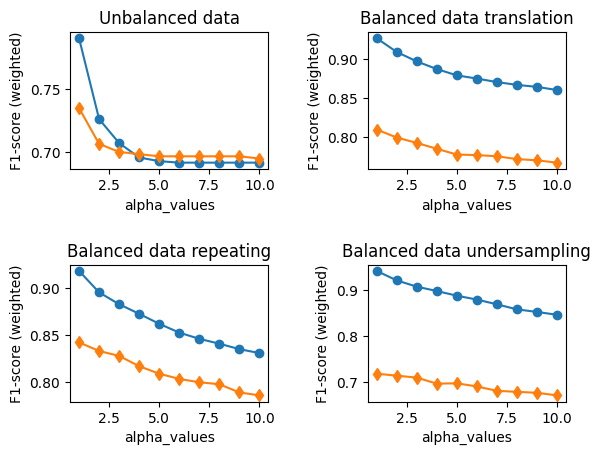

In [41]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(alpha_values, scores_data3_unbalanced[0], '-o', label='Train')
axs[0, 0].plot(alpha_values, scores_data3_unbalanced[1], '-d', label='Test')
axs[0, 0].set_title('Unbalanced data')
axs[0, 1].plot(alpha_values, scores_data3_balanced_translate[0], '-o', label='Train')
axs[0, 1].plot(alpha_values, scores_data3_balanced_translate[1], '-d', label='Test')
axs[0, 1].set_title('Balanced data translation')
axs[1, 0].plot(alpha_values, scores_data3_balanced_repeating[0], '-o', label='Train')
axs[1, 0].plot(alpha_values, scores_data3_balanced_repeating[1], '-d', label='Test')
axs[1, 0].set_title('Balanced data repeating')
axs[1, 1].plot(alpha_values, scores_data3_balanced_undersampl[0], '-o', label='Train')
axs[1, 1].plot(alpha_values, scores_data3_balanced_undersampl[1], '-d', label='Test')
axs[1, 1].set_title('Balanced data undersampling')

for ax in axs.flat:
    ax.set(xlabel='alpha_values', ylabel='F1-score (weighted)')

plt.subplots_adjust(hspace=0.7, wspace = 0.5)

plt.show()

In [42]:
mnb = MultinomialNB(alpha=2) # alpha chosen based on graph above

def multinomial_nb(X_train, X_val, y_train, y_val, preproc):
    mnb_bow = Pipeline([
        ('bow', CountVectorizer(analyzer=preproc, ngram_range=(1,1))),  # strings to token integer counts
        ('classifier', mnb),  # train on TF-IDF vectors w/ LinearSVC classifier
    ])

    mnb_bow.fit(X_train, y_train)
    result_val1 = mnb_bow.predict(X_val)
    print('BOW')
    print(confusion_matrix(y_val, result_val1))
    f1_bow = f1_score(y_val, result_val1, average='weighted')
    
    mnb_tfidf = Pipeline([
        ('bow', CountVectorizer(analyzer=preproc, ngram_range=(1,1))),  # strings to token integer counts
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('classifier', mnb),  # train on TF-IDF vectors w/ LinearSVC classifier
    ])
    
    mnb_tfidf.fit(X_train, y_train)
    result_val2 = mnb_tfidf.predict(X_val)
    print('TF-IDF')
    print(confusion_matrix(y_val, result_val2))
    f1_tfidf = f1_score(y_val, result_val2, average='weighted')
    
    return f1_bow, f1_tfidf, mnb_bow, mnb_tfidf

In [43]:
print('UNBALANCED')
f1_val[1][0], f1_val[1][1], mnb_bow_unb1, mnb_tfidf_unb1 = multinomial_nb(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing1)
f1_test[1][0] = predict_test(X_test_unb, y_test_unb, mnb_bow_unb1)
f1_test[1][1] = predict_test(X_test_unb, y_test_unb, mnb_tfidf_unb1)

f1_val[4][0], f1_val[4][1], mnb_bow_unb2, mnb_tfidf_unb2 = multinomial_nb(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing2)
f1_test[4][0] = predict_test(X_test_unb, y_test_unb, mnb_bow_unb2)
f1_test[4][1] = predict_test(X_test_unb, y_test_unb, mnb_tfidf_unb2)

f1_val[7][0], f1_val[7][1], mnb_bow_unb3, mnb_tfidf_unb3 = multinomial_nb(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing3)
f1_test[7][0] = predict_test(X_test_unb, y_test_unb, mnb_bow_unb3)
f1_test[7][1] = predict_test(X_test_unb, y_test_unb, mnb_tfidf_unb3)

f1_val[10][0], f1_val[10][1], mnb_bow_unb4, mnb_tfidf_unb4 = multinomial_nb(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing4)
f1_test[10][0] = predict_test(X_test_unb, y_test_unb, mnb_bow_unb4)
f1_test[10][1] = predict_test(X_test_unb, y_test_unb, mnb_tfidf_unb4)


print('UNDERSAMPLING')
f1_val[1][2], f1_val[1][3], mnb_bow_und1, mnb_tfidf_und1 = multinomial_nb(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing1)
f1_test[1][2] = predict_test(X_test_und, y_test_und, mnb_bow_und1)
f1_test[1][3] = predict_test(X_test_und, y_test_und, mnb_tfidf_und1)

f1_val[4][2], f1_val[4][3], mnb_bow_und2, mnb_tfidf_und2 = multinomial_nb(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing2)
f1_test[4][2] = predict_test(X_test_und, y_test_und, mnb_bow_und2)
f1_test[4][3] = predict_test(X_test_und, y_test_und, mnb_tfidf_und2)

f1_val[7][2], f1_val[7][3], mnb_bow_und3, mnb_tfidf_und3 = multinomial_nb(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing3)
f1_test[7][2] = predict_test(X_test_und, y_test_und, mnb_bow_und3)
f1_test[7][3] = predict_test(X_test_und, y_test_und, mnb_tfidf_und3)

f1_val[10][2], f1_val[10][3], mnb_bow_und4, mnb_tfidf_und4 = multinomial_nb(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing4)
f1_test[10][2] = predict_test(X_test_und, y_test_und, mnb_bow_und4)
f1_test[10][3] = predict_test(X_test_und, y_test_und, mnb_tfidf_und4)


print('REPEATING')
f1_val[1][4], f1_val[1][5], mnb_bow_rep1, mnb_tfidf_rep1 = multinomial_nb(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing1)
f1_test[1][4] = predict_test(X_test_rep, y_test_rep, mnb_bow_rep1)
f1_test[1][5] = predict_test(X_test_rep, y_test_rep, mnb_tfidf_rep1)

f1_val[4][4], f1_val[4][5], mnb_bow_rep2, mnb_tfidf_rep2 = multinomial_nb(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing2)
f1_test[4][4] = predict_test(X_test_rep, y_test_rep, mnb_bow_rep2)
f1_test[4][5] = predict_test(X_test_rep, y_test_rep, mnb_tfidf_rep2)

f1_val[7][4], f1_val[7][5], mnb_bow_rep3, mnb_tfidf_rep3 = multinomial_nb(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing3)
f1_test[7][4] = predict_test(X_test_rep, y_test_rep, mnb_bow_rep3)
f1_test[7][5] = predict_test(X_test_rep, y_test_rep, mnb_tfidf_rep3)

f1_val[10][4], f1_val[10][5], mnb_bow_rep4, mnb_tfidf_rep4 = multinomial_nb(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing4)
f1_test[10][4] = predict_test(X_test_rep, y_test_rep, mnb_bow_rep4)
f1_test[10][5] = predict_test(X_test_rep, y_test_rep, mnb_tfidf_rep4)

print('TRANSLATION')
f1_val[1][6], f1_val[1][7], mnb_bow_tra1, mnb_tfidf_tra1 = multinomial_nb(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing1)
f1_test[1][6] = predict_test(X_test_tra, y_test_tra, mnb_bow_tra1)
f1_test[1][7] = predict_test(X_test_tra, y_test_tra, mnb_tfidf_tra1)

f1_val[4][6], f1_val[4][7], mnb_bow_tra2, mnb_tfidf_tra2 = multinomial_nb(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing2)
f1_test[4][6] = predict_test(X_test_tra, y_test_tra, mnb_bow_tra2)
f1_test[4][7] = predict_test(X_test_tra, y_test_tra, mnb_tfidf_tra2)

f1_val[7][6], f1_val[7][7], mnb_bow_tra3, mnb_tfidf_tra3 = multinomial_nb(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing3)
f1_test[7][6] = predict_test(X_test_tra, y_test_tra, mnb_bow_tra3)
f1_test[7][7] = predict_test(X_test_tra, y_test_tra, mnb_tfidf_tra3)

f1_val[10][6], f1_val[10][7], mnb_bow_tra4, mnb_tfidf_tra4 = multinomial_nb(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing4)
f1_test[10][6] = predict_test(X_test_tra, y_test_tra, mnb_bow_tra4)
f1_test[10][7] = predict_test(X_test_tra, y_test_tra, mnb_tfidf_tra4)

UNBALANCED
BOW
[[1036   20]
 [ 186  102]]
TF-IDF
[[1055    1]
 [ 277   11]]
[[1060    7]
 [ 217   61]]
[[1067    0]
 [ 268   10]]
BOW
[[1035   21]
 [ 188  100]]
TF-IDF
[[1055    1]
 [ 279    9]]
[[1060    7]
 [ 219   59]]
[[1067    0]
 [ 270    8]]
BOW
[[1031   25]
 [ 209   79]]
TF-IDF
[[1056    0]
 [ 283    5]]
[[1059    8]
 [ 241   37]]
[[1067    0]
 [ 278    0]]
BOW
[[1035   21]
 [ 190   98]]
TF-IDF
[[1055    1]
 [ 279    9]]
[[1060    7]
 [ 220   58]]
[[1067    0]
 [ 270    8]]
UNDERSAMPLING
BOW
[[171 113]
 [ 38 251]]
TF-IDF
[[159 125]
 [ 26 263]]
[[158 143]
 [ 29 243]]
[[173 128]
 [ 31 241]]
BOW
[[172 112]
 [ 40 249]]
TF-IDF
[[158 126]
 [ 33 256]]
[[176 125]
 [ 33 239]]
[[181 120]
 [ 34 238]]
BOW
[[171 113]
 [ 34 255]]
TF-IDF
[[157 127]
 [ 22 267]]
[[156 145]
 [ 24 248]]
[[169 132]
 [ 26 246]]
BOW
[[173 111]
 [ 39 250]]
TF-IDF
[[157 127]
 [ 32 257]]
[[177 124]
 [ 33 239]]
[[184 117]
 [ 34 238]]
REPEATING
BOW
[[ 791  261]
 [  55 1009]]
TF-IDF
[[ 744  308]
 [  48 1016]]
[[ 643  426]

#### 5.2.3 LinearSVC

In [44]:
param_C = np.logspace(-5, 4, 10)
def linear_svc_eval(data):
    train_scores = []
    val_scores = []
    for i in param_C:
        clf = LinearSVC(C=i, max_iter=10000)
        pipeline = Pipeline([
                            ('bow', CountVectorizer(analyzer=preprocessing4, ngram_range=(1,1))),  # strings to token integer counts
                            ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
                            ('classifier', clf) # train on TF-IDF vectors w/ LinearSVC classifier
                            ])
        
        pipeline.fit(data[0], data[2])
        
        train_predict = pipeline.predict(data[0])
        train_f1 = f1_score(data[2], train_predict, average='weighted')
        train_scores.append(train_f1)
        
        val_predict = pipeline.predict(data[1])
        val_f1 = f1_score(data[3], val_predict, average='weighted')
        val_scores.append(val_f1)  
        
    return [train_scores, val_scores]

In [45]:
scores_data3_unbalanced = linear_svc_eval([X_train_unb, X_val_unb, y_train_unb, y_val_unb])
scores_data3_balanced_translate = linear_svc_eval([X_train_tra, X_val_tra, y_train_tra, y_val_tra])
scores_data3_balanced_repeating = linear_svc_eval([X_train_rep, X_val_rep, y_train_rep, y_val_rep])
scores_data3_balanced_undsampl = linear_svc_eval([X_train_und, X_val_und, y_train_und, y_val_und])

c:\users\acer\onedrive\documentos\studies\tcc\hate_speech_detector\venv\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\acer\onedrive\documentos\studies\tcc\hate_speech_detector\venv\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\acer\onedrive\documentos\studies\tcc\hate_speech_detector\venv\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\acer\onedrive\documentos\studies\tcc\hate_speech_detector\venv\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Libli

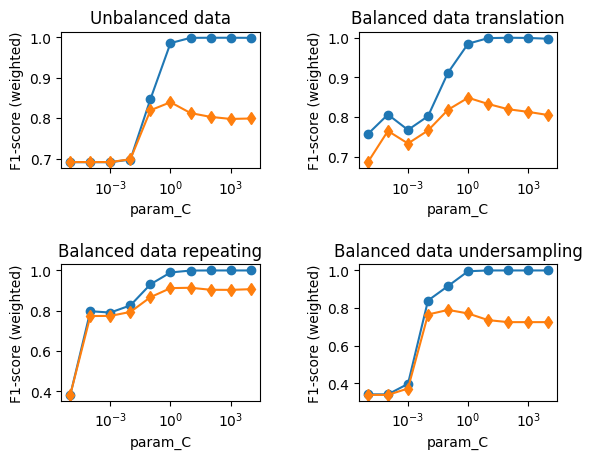

In [46]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(param_C, scores_data3_unbalanced[0], '-o', label='Train')
axs[0, 0].plot(param_C, scores_data3_unbalanced[1], '-d', label='Test')
axs[0, 0].set_title('Unbalanced data')
axs[0, 1].plot(param_C, scores_data3_balanced_translate[0], '-o', label='Train')
axs[0, 1].plot(param_C, scores_data3_balanced_translate[1], '-d', label='Test')
axs[0, 1].set_title('Balanced data translation')
axs[1, 0].plot(param_C, scores_data3_balanced_repeating[0], '-o', label='Train')
axs[1, 0].plot(param_C, scores_data3_balanced_repeating[1], '-d', label='Test')
axs[1, 0].set_title('Balanced data repeating')
axs[1, 1].plot(param_C, scores_data3_balanced_undsampl[0], '-o', label='Train')
axs[1, 1].plot(param_C, scores_data3_balanced_undsampl[1], '-d', label='Test')
axs[1, 1].set_title('Balanced data undersampling')

for ax in axs.flat:
    ax.set(xlabel='param_C', ylabel='F1-score (weighted)')
    ax.set_xscale('log')


plt.subplots_adjust(hspace=0.7, wspace = 0.5)

plt.show()

In [47]:
lsvc = LinearSVC(C=10**-2) # C chosen based on graph above

def linearsvc(X_train, X_val, y_train, y_val, preproc):
    lsvc_bow = Pipeline([
        ('bow', CountVectorizer(analyzer=preproc, ngram_range=(1,1))),  # strings to token integer counts
        ('classifier', lsvc),  # train on TF-IDF vectors w/ LinearSVC classifier
    ])

    lsvc_bow.fit(X_train, y_train)
    result_val1 = lsvc_bow.predict(X_val)
    print('BOW')
    print(confusion_matrix(y_val, result_val1))
    f1_bow = f1_score(y_val, result_val1, average='weighted')
    
    lsvc_tfidf = Pipeline([
        ('bow', CountVectorizer(analyzer=preproc, ngram_range=(1,1))),  # strings to token integer counts
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('classifier', lsvc),  # train on TF-IDF vectors w/ LinearSVC classifier
    ])
    
    lsvc_tfidf.fit(X_train, y_train)
    result_val2 = lsvc_tfidf.predict(X_val)
    print('TF-IDF')
    print(confusion_matrix(y_val, result_val2))
    f1_tfidf = f1_score(y_val, result_val2, average='weighted')
    
    return f1_bow, f1_tfidf, lsvc_tfidf, lsvc_tfidf

In [48]:
print('UNBALANCED')
f1_val[2][0], f1_val[2][1], lsvc_bow_unb1, lsvc_tfidf_unb1 = linearsvc(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing1)
f1_test[2][0] = predict_test(X_test_unb, y_test_unb, lsvc_bow_unb1)
f1_test[2][1] = predict_test(X_test_unb, y_test_unb, lsvc_tfidf_unb1)

f1_val[5][0], f1_val[5][1], lsvc_bow_unb2, lsvc_tfidf_unb2 = linearsvc(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing2)
f1_test[5][0] = predict_test(X_test_unb, y_test_unb, lsvc_bow_unb2)
f1_test[5][1] = predict_test(X_test_unb, y_test_unb, lsvc_tfidf_unb2)

f1_val[8][0], f1_val[8][1], lsvc_bow_unb3, lsvc_tfidf_unb3 = linearsvc(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing3)
f1_test[8][0] = predict_test(X_test_unb, y_test_unb, lsvc_bow_unb3)
f1_test[8][1] = predict_test(X_test_unb, y_test_unb, lsvc_tfidf_unb3)

f1_val[11][0], f1_val[11][1], lsvc_bow_unb4, lsvc_tfidf_unb4 = linearsvc(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing4)
f1_test[11][0] = predict_test(X_test_unb, y_test_unb, lsvc_bow_unb4)
f1_test[11][1] = predict_test(X_test_unb, y_test_unb, lsvc_tfidf_unb4)


print('UNDERSAMPLING')
f1_val[2][2], f1_val[2][3], lsvc_bow_und1, lsvc_tfidf_und1 = linearsvc(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing1)
f1_test[2][2] = predict_test(X_test_und, y_test_und, lsvc_bow_und1)
f1_test[2][3] = predict_test(X_test_und, y_test_und, lsvc_tfidf_und1)

f1_val[5][2], f1_val[5][3], lsvc_bow_und2, lsvc_tfidf_und2 = linearsvc(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing2)
f1_test[5][2] = predict_test(X_test_und, y_test_und, lsvc_bow_und2)
f1_test[5][3] = predict_test(X_test_und, y_test_und, lsvc_tfidf_und2)

f1_val[8][2], f1_val[8][3], lsvc_bow_und3, lsvc_tfidf_und3 = linearsvc(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing3)
f1_test[8][2] = predict_test(X_test_und, y_test_und, lsvc_bow_und3)
f1_test[8][3] = predict_test(X_test_und, y_test_und, lsvc_tfidf_und3)

f1_val[11][2], f1_val[11][3], lsvc_bow_und4, lsvc_tfidf_und4 = linearsvc(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing4)
f1_test[11][2] = predict_test(X_test_und, y_test_und, lsvc_bow_und4)
f1_test[11][3] = predict_test(X_test_und, y_test_und, lsvc_tfidf_und4)


print('REPEATING')
f1_val[2][4], f1_val[2][5], lsvc_bow_rep1, lsvc_tfidf_rep1 = linearsvc(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing1)
f1_test[2][4] = predict_test(X_test_rep, y_test_rep, lsvc_bow_rep1)
f1_test[2][5] = predict_test(X_test_rep, y_test_rep, lsvc_tfidf_rep1)

f1_val[5][4], f1_val[5][5], lsvc_bow_rep2, lsvc_tfidf_rep2 = linearsvc(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing2)
f1_test[5][4] = predict_test(X_test_rep, y_test_rep, lsvc_bow_rep2)
f1_test[5][5] = predict_test(X_test_rep, y_test_rep, lsvc_tfidf_rep2)

f1_val[8][4], f1_val[8][5], lsvc_bow_rep3, lsvc_tfidf_rep3 = linearsvc(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing3)
f1_test[8][4] = predict_test(X_test_rep, y_test_rep, lsvc_bow_rep3)
f1_test[8][5] = predict_test(X_test_rep, y_test_rep, lsvc_tfidf_rep3)

f1_val[11][4], f1_val[11][5], lsvc_bow_rep4, lsvc_tfidf_rep4 = linearsvc(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing4)
f1_test[11][4] = predict_test(X_test_rep, y_test_rep, lsvc_bow_rep4)
f1_test[11][5] = predict_test(X_test_rep, y_test_rep, lsvc_tfidf_rep4)

print('TRANSLATION')
f1_val[2][6], f1_val[2][7], lsvc_bow_tra1, lsvc_tfidf_tra1 = linearsvc(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing1)
f1_test[2][6] = predict_test(X_test_tra, y_test_tra, lsvc_bow_tra1)
f1_test[2][7] = predict_test(X_test_tra, y_test_tra, lsvc_tfidf_tra1)

f1_val[5][6], f1_val[5][7], lsvc_bow_tra2, lsvc_tfidf_tra2 = linearsvc(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing2)
f1_test[5][6] = predict_test(X_test_tra, y_test_tra, lsvc_bow_tra2)
f1_test[5][7] = predict_test(X_test_tra, y_test_tra, lsvc_tfidf_tra2)

f1_val[8][6], f1_val[8][7], lsvc_bow_tra3, lsvc_tfidf_tra3 = linearsvc(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing3)
f1_test[8][6] = predict_test(X_test_tra, y_test_tra, lsvc_bow_tra3)
f1_test[8][7] = predict_test(X_test_tra, y_test_tra, lsvc_tfidf_tra3)

f1_val[11][6], f1_val[11][7], lsvc_bow_tra4, lsvc_tfidf_tra4 = linearsvc(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing4)
f1_test[11][6] = predict_test(X_test_tra, y_test_tra, lsvc_bow_tra4)
f1_test[11][7] = predict_test(X_test_tra, y_test_tra, lsvc_tfidf_tra4)

UNBALANCED
BOW
[[1042   14]
 [ 183  105]]
TF-IDF
[[1056    0]
 [ 285    3]]
[[1067    0]
 [ 277    1]]
[[1067    0]
 [ 277    1]]
BOW
[[1043   13]
 [ 185  103]]
TF-IDF
[[1056    0]
 [ 285    3]]
[[1067    0]
 [ 273    5]]
[[1067    0]
 [ 273    5]]
BOW
[[1030   26]
 [ 192   96]]
TF-IDF
[[1054    2]
 [ 271   17]]
[[1062    5]
 [ 262   16]]
[[1062    5]
 [ 262   16]]
BOW
[[1043   13]
 [ 184  104]]
TF-IDF
[[1056    0]
 [ 284    4]]
[[1067    0]
 [ 273    5]]
[[1067    0]
 [ 273    5]]
UNDERSAMPLING
BOW
[[254  30]
 [110 179]]
TF-IDF
[[236  48]
 [ 83 206]]
[[242  59]
 [ 80 192]]
[[242  59]
 [ 80 192]]
BOW
[[250  34]
 [ 91 198]]
TF-IDF
[[233  51]
 [ 78 211]]
[[242  59]
 [ 74 198]]
[[242  59]
 [ 74 198]]
BOW
[[249  35]
 [103 186]]
TF-IDF
[[245  39]
 [101 188]]
[[265  36]
 [ 95 177]]
[[265  36]
 [ 95 177]]
BOW
[[247  37]
 [ 87 202]]
TF-IDF
[[230  54]
 [ 80 209]]
[[243  58]
 [ 76 196]]
[[243  58]
 [ 76 196]]
REPEATING
BOW
[[987  65]
 [258 806]]
TF-IDF
[[981  71]
 [405 659]]
[[963 106]
 [378 669

In [49]:
f1_val

array([[0.69142857, 0.69142857, 0.72937027, 0.70972753, 0.75735644,
        0.7520878 , 0.73086393, 0.70161423],
       [0.82128219, 0.70995932, 0.7315632 , 0.72792935, 0.84914772,
        0.82905606, 0.81109493, 0.80690562],
       [0.82842069, 0.6967122 , 0.75112914, 0.77064557, 0.84615377,
        0.76951583, 0.80085537, 0.76072564],
       [0.69142857, 0.69142857, 0.75581471, 0.71164216, 0.77750496,
        0.77115858, 0.71958915, 0.72501795],
       [0.81844406, 0.70660751, 0.73016789, 0.7145783 , 0.84751639,
        0.83566227, 0.8112107 , 0.7972457 ],
       [0.8268652 , 0.6967122 , 0.7798642 , 0.77446121, 0.83705142,
        0.79888503, 0.79848085, 0.76468354],
       [0.69142857, 0.69142857, 0.74867273, 0.74501901, 0.74992284,
        0.76933044, 0.73070902, 0.72371311],
       [0.7920074 , 0.70018556, 0.73815649, 0.73046754, 0.84353329,
        0.81996127, 0.80545496, 0.79847244],
       [0.81087145, 0.71935806, 0.75598143, 0.75301577, 0.83512836,
        0.76457126, 0.791862

In [50]:
f1_test

array([[0.70187415, 0.70187415, 0.71541791, 0.73369292, 0.73487269,
        0.74106346, 0.72059874, 0.71355831],
       [0.79037714, 0.71914976, 0.69076707, 0.71685886, 0.77130586,
        0.79719939, 0.7963777 , 0.81132983],
       [0.70364692, 0.70364692, 0.75663537, 0.75663537, 0.76710091,
        0.76710091, 0.76348894, 0.76348894],
       [0.70187415, 0.70187415, 0.73462249, 0.73246677, 0.76020616,
        0.76584341, 0.71757031, 0.71766636],
       [0.78778579, 0.71577299, 0.71933105, 0.72718635, 0.780883  ,
        0.80666744, 0.78632655, 0.80642918],
       [0.71063572, 0.71063572, 0.76741895, 0.76741895, 0.79482633,
        0.79482633, 0.76328422, 0.76328422],
       [0.70187415, 0.70187415, 0.70658122, 0.74803917, 0.75313561,
        0.75004737, 0.70923041, 0.71835123],
       [0.75720877, 0.70187415, 0.69479656, 0.71727751, 0.75776541,
        0.78995427, 0.78334382, 0.80229031],
       [0.72684159, 0.72684159, 0.7676761 , 0.7676761 , 0.7554716 ,
        0.7554716 , 0.735059

## 6. Check the best model and use test data

Figure: F1-score for all the pipelines tested - validation data
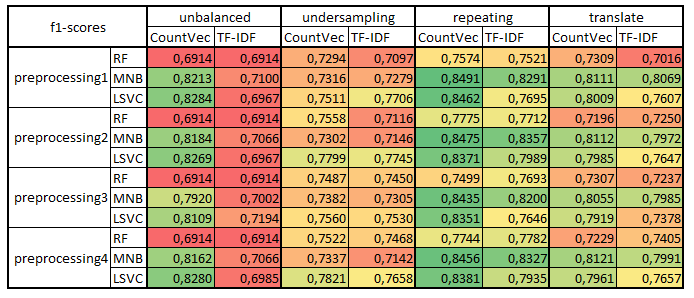

Remarks:
* Unbalanced data had the same values of f1-score in all cases, as the model got 100% right in the majority class and 0% right in the minority class
* Undersampling data had a lower f1-score


Figure: F1-score for all the pipelines tested - test data
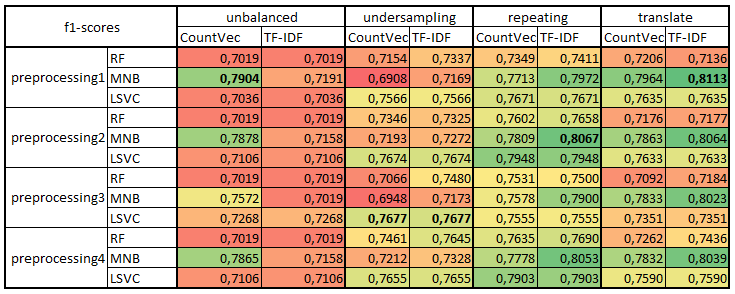


* Model created based in undersampling: can have problems with generalization, as the model was exposed to less data;
* Model created based in repeating: can be skewed;
* Model created based in translation: although f1-score is lower than "repeating", this model had access to other data, as the data of minority class was replicated with some random elements.

In [72]:
# saving the best model: mnb_tfidf_tra1

import joblib

mnb = MultinomialNB(alpha=2) # alpha chosen based on graph above
mod = Pipeline([
        ('bow', CountVectorizer(analyzer=preprocessing1, ngram_range=(1,1))),  # strings to token integer counts
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('classifier', mnb),  # train on TF-IDF vectors w/ LinearSVC classifier
    ])

mod.fit(X_train_tra, y_train_tra)
filename = 'mnb_tfidf_tra1.sav'
joblib.dump(mod, filename)

['mnb_tfidf_tra1.sav']

In [73]:
# load the model from disk
loaded_model = joblib.load("mnb_tfidf_tra1.sav")

In [74]:
loaded_model

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function preprocessing1 at 0x00000193FF27D670>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB(alpha=2))])

## 7. Checking model with new data

In [54]:
import tweepy
import sys
import json

In [55]:
#autentications
consumer_key = 'CYm5BexxGzlrX64q8wTCoh2NU'
consumer_secret = 'g0QjKZecBRebTbS7lBUapKZQTSP3wcvg4MP7Ks4RJOOyF3UuFT'
access_token = '1200906763308019717-oawvMMkme3g2jYMy7Yr9qwHO0VSv57'
access_token_secret = 'a0UL1nuKRms6s0F5RXN5ZnBMcML5viKy73PXC2DZomUE1'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [56]:
import tqdm

BRAZIL_WOE_ID = 23424768
brazil_trends = api.trends_place(BRAZIL_WOE_ID)[0]['trends'][:20]

tweets_df = pd.DataFrame(columns=['topic', 'text', 'RT', 'time'])

qt_items = 1000

for brazil_trend in brazil_trends:
    search_words = brazil_trend['name']
    print(search_words)
    
    tweets = tweepy.Cursor(api.search,
                           q=search_words,
                           tweet_mode = "extended",
                           lang="pt").items(qt_items)
    
    for tweet in tqdm.tqdm(tweets):
        try:
            text = tweet.retweeted_status.full_text
            rt = "1"
        except AttributeError:
            text = tweet.full_text
            rt = "0"

        tweets_df = tweets_df.append({'topic':search_words,
                                      'text': text,
                                      'RT': rt,
                                      'time': tweet.created_at},
                                     ignore_index=True)
    time.sleep(60 * 8)

0it [00:00, ?it/s]

#ForaArthur


1000it [01:49,  9.16it/s]
0it [00:00, ?it/s]

Camilla


1000it [01:50,  9.05it/s]
0it [00:00, ?it/s]

#NoLimite


1000it [01:53,  8.79it/s]
0it [00:00, ?it/s]

zendaya


1000it [02:00,  8.32it/s]
0it [00:00, ?it/s]

Oscar


1000it [01:44,  9.53it/s]
0it [00:00, ?it/s]

Tiago


1000it [01:49,  9.15it/s]
0it [00:00, ?it/s]

Jessica


1000it [01:49,  9.14it/s]
0it [00:00, ?it/s]

Gil do Vigor


1000it [01:54,  8.72it/s]
0it [00:00, ?it/s]

H.E.R


1000it [01:58,  8.42it/s]
0it [00:00, ?it/s]

Galeano


1000it [01:52,  8.90it/s]
0it [00:00, ?it/s]

BBB 18


1000it [01:51,  8.93it/s]
0it [00:00, ?it/s]

Iris


1000it [01:50,  9.05it/s]
0it [00:00, ?it/s]

Agora o Arthur


1000it [01:50,  9.04it/s]
0it [00:00, ?it/s]

Siri


1000it [02:02,  8.19it/s]
0it [00:00, ?it/s]

Elana


1000it [01:54,  8.73it/s]
0it [00:00, ?it/s]

André


1000it [01:49,  9.13it/s]
0it [00:00, ?it/s]

Ariadna


1000it [01:58,  8.42it/s]
0it [00:00, ?it/s]

Ana Clara


1000it [01:54,  8.74it/s]
0it [00:00, ?it/s]

Mahmoud


1000it [01:55,  8.65it/s]
0it [00:00, ?it/s]

Igor Vinicius


1000it [02:00,  8.28it/s]


In [57]:
tweets_df

,topic,text,RT,time
0,#ForaArthur,A Bonita escapou mais uma vez. Agora vamos de ...,1,2021-04-26 02:45:55
1,#ForaArthur,Juliette falando que não está triste porque te...,1,2021-04-26 02:45:55
2,#ForaArthur,"SINCERAMENTE, SOU #ForaArthur!!!! E vamos de #...",1,2021-04-26 02:45:55
3,#ForaArthur,"Sterellas que gostam da Pocah, vamos de #ForaA...",1,2021-04-26 02:45:55
4,#ForaArthur,Juliette falando que não está triste porque te...,1,2021-04-26 02:45:55
...,...,...,...,...
19995,Igor Vinicius,Fim de jogo! #ITUxSPFC (0-3)\n\n⚽ Rodrigo \n⚽ ...,1,2021-04-26 03:11:36
19996,Igor Vinicius,Fim de jogo! #ITUxSPFC (0-3)\n\n⚽ Rodrigo \n⚽ ...,1,2021-04-26 03:11:36
19997,Igor Vinicius,Fim de jogo! #ITUxSPFC (0-3)\n\n⚽ Rodrigo \n⚽ ...,1,2021-04-26 03:11:36
19998,Igor Vinicius,Fim de jogo! #ITUxSPFC (0-3)\n\n⚽ Rodrigo \n⚽ ...,1,2021-04-26 03:11:35


In [58]:
def count_swear_words(text):
    swear = []
    text = text.split(' ')
    for swear_word in list_bad_words:
        try:
            x = [re.findall('^' + swear_word.lower(), word) for word in text]
            x = [y for y in x if y != []]
            if x != []:
                swear.append(x[0][0])
        except:
            pass
    return len(swear)

tweets_df['swear_words'] = tweets_df['text'].apply(count_swear_words)

In [59]:
tweets_df

,topic,text,RT,time,swear_words
0,#ForaArthur,A Bonita escapou mais uma vez. Agora vamos de ...,1,2021-04-26 02:45:55,0
1,#ForaArthur,Juliette falando que não está triste porque te...,1,2021-04-26 02:45:55,0
2,#ForaArthur,"SINCERAMENTE, SOU #ForaArthur!!!! E vamos de #...",1,2021-04-26 02:45:55,0
3,#ForaArthur,"Sterellas que gostam da Pocah, vamos de #ForaA...",1,2021-04-26 02:45:55,0
4,#ForaArthur,Juliette falando que não está triste porque te...,1,2021-04-26 02:45:55,0
...,...,...,...,...,...
19995,Igor Vinicius,Fim de jogo! #ITUxSPFC (0-3)\n\n⚽ Rodrigo \n⚽ ...,1,2021-04-26 03:11:36,0
19996,Igor Vinicius,Fim de jogo! #ITUxSPFC (0-3)\n\n⚽ Rodrigo \n⚽ ...,1,2021-04-26 03:11:36,0
19997,Igor Vinicius,Fim de jogo! #ITUxSPFC (0-3)\n\n⚽ Rodrigo \n⚽ ...,1,2021-04-26 03:11:36,0
19998,Igor Vinicius,Fim de jogo! #ITUxSPFC (0-3)\n\n⚽ Rodrigo \n⚽ ...,1,2021-04-26 03:11:35,0


In [75]:
tweets_df['hate'] = loaded_model.predict(tweets_df['text'])

In [76]:
tweets_df

,topic,text,RT,time,swear_words,hate
0,#ForaArthur,A Bonita escapou mais uma vez. Agora vamos de ...,1,2021-04-26 02:45:55,0,1
1,#ForaArthur,Juliette falando que não está triste porque te...,1,2021-04-26 02:45:55,0,0
2,#ForaArthur,"SINCERAMENTE, SOU #ForaArthur!!!! E vamos de #...",1,2021-04-26 02:45:55,0,1
3,#ForaArthur,"Sterellas que gostam da Pocah, vamos de #ForaA...",1,2021-04-26 02:45:55,0,1
4,#ForaArthur,Juliette falando que não está triste porque te...,1,2021-04-26 02:45:55,0,0
...,...,...,...,...,...,...
19995,Igor Vinicius,Fim de jogo! #ITUxSPFC (0-3)\n\n⚽ Rodrigo \n⚽ ...,1,2021-04-26 03:11:36,0,0
19996,Igor Vinicius,Fim de jogo! #ITUxSPFC (0-3)\n\n⚽ Rodrigo \n⚽ ...,1,2021-04-26 03:11:36,0,0
19997,Igor Vinicius,Fim de jogo! #ITUxSPFC (0-3)\n\n⚽ Rodrigo \n⚽ ...,1,2021-04-26 03:11:36,0,0
19998,Igor Vinicius,Fim de jogo! #ITUxSPFC (0-3)\n\n⚽ Rodrigo \n⚽ ...,1,2021-04-26 03:11:35,0,0


In [78]:
tweets_df.to_csv('tweets.csv', index=False)